In [ ]:
%pip install nbconvert[webpdf]

In [ ]:
import os

# For example:
# You could put this at the top of your program
# to set a value for the variable named CENSUS_API_KEY.
os.environ["CENSUS_API_KEY"] = "2d7297910dd1faf19164ab082cdcf9d696523ab0"

# Estimating space- and time-varying transmission rate from data

In [1]:
from epymorph.adrio import us_tiger
from epymorph.data import ipm, mm
from epymorph.geography.us_census import StateScope
import epymorph.initializer as init
from epymorph.rume import SingleStrataRUME
from epymorph.simulation import default_rng
from epymorph.simulator.basic.basic_simulator import BasicSimulator
from epymorph.time import TimeFrame

In [2]:
#CustomScopes give you the most flexibility in representing geography.

#nodes = number of locations
#node IDS = A,B,C: the name of our grid_cell/polygons
#node labels is the same as the ID
from epymorph.kit import *

scope = CustomScope(["A", "B", "C", "D", "E", "F", "G", "H"])

In [3]:
import numpy as np

centroids = np.array(
    [
        #(-111.5, 33.8),
        #(-106.6, 35.2),
        #(-109.3, 32.1),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
    ],
    dtype=CentroidDType  # already imported with epymorph.kit
)



In [10]:
"""Defines a compartmental IPM for a generic SIRS model."""

from sympy import Max

from epymorph.attribute import AttributeDef
from epymorph.compartment_model import CompartmentModel, compartment, edge
from epymorph.data_shape import Shapes


class SIRS_TREES(CompartmentModel):
    """A basic SIRS model."""

    compartments = [
        compartment("S", tags=["immobile"]), #Susceptible
        compartment("I1", tags=["immobile"]), #INFECTIOUS STAGE 1
        compartment("I2", tags=["immobile"]), #INFECTIOUS STAGE 2
        compartment("I3", tags=["immobile"]), #INFECTIOUS STAGE 3
        compartment("R", tags=["immobile"]), #RECOVERED
        compartment("D", tags=["immobile"]), #DEATH
        compartment("X", tags=["mobile"]), #INSECT
    ]

    requirements = [
        AttributeDef("beta", type=float, shape=Shapes.TxN, comment="infectivity"),
        AttributeDef(
            "gamma",
            type=float,
            shape=Shapes.TxN,
            comment="progression from infected to recovered",
        ),
        AttributeDef(
            "xi",
            type=float,
            shape=Shapes.TxN,
            comment="progression from recovered to susceptible",
        ),
    ]

    def edges(self, symbols):
        [S, I1, I2, I3, R, D, X] = symbols.all_compartments
        [β, γ, ξ] = symbols.all_requirements

        # formulate N so as to avoid dividing by zero;
        # this is safe in this instance because if the denominator is zero,
        # the numerator must also be zero
        N = Max(1, S + I1 + I2 + I3 + R + D + X)

        return [
            edge(S, X, rate=β * S * X / N),
            edge(S, I1, rate=γ * I1),
            edge(I1, I2, rate=γ * I2),
            edge(I2, I3, rate=γ * I3),
            edge(I3, D, rate=γ * D),
            edge(I1, R, rate=ξ * I1),
            edge(I2, R, rate=ξ * I2),
            edge(I3, R, rate=ξ * I3),
            edge(R, S, rate=ξ * R),             
        ]


In [8]:
from functools import cached_property

import numpy as np
from numpy.typing import NDArray

from epymorph.attribute import AttributeDef
from epymorph.data_shape import Shapes
from epymorph.data_type import CentroidType, SimDType
from epymorph.movement_model import EveryDay, MovementClause, MovementModel
from epymorph.simulation import Tick, TickDelta, TickIndex
from epymorph.util import pairwise_haversine, row_normalize


class CentroidsClause(MovementClause):
    """The clause of the centroids model."""

    requirements = (
        AttributeDef(
            "population", int, Shapes.N, comment="The total population at each node."
        ),
        AttributeDef(
            "centroid",
            CentroidType,
            Shapes.N,
            comment="The centroids for each node as (longitude, latitude) tuples.",
        ),
        AttributeDef(
            "phi",
            float,
            Shapes.Scalar,
            default_value=40.0, #can this be NA since we dont know how far they can travel?
            comment="Influences the distance that movers tend to travel.",
        ),
        AttributeDef(
            "commuter_proportion",
            float,
            Shapes.Scalar,
            default_value=0.1,
            comment="The proportion of the total population which commutes.",
        ),
    )

    predicate = EveryDay()
    leaves = TickIndex(step=0)
    returns = TickDelta(step=1, days=0)

    @cached_property
    def dispersal_kernel(self) -> NDArray[np.float64]:
        """
        The NxN matrix or dispersal kernel describing the tendency for movers to move
        to a particular location. In this model, the kernel is:
            1 / e ^ (distance / phi)
        which is then row-normalized.
        """
        centroid = self.data("centroid")
        phi = self.data("phi")
        distance = pairwise_haversine(centroid)
        return row_normalize(1 / np.exp(distance / phi))

    def evaluate(self, tick: Tick) -> NDArray[np.int64]:
        pop = self.data("population")
        comm_prop = self.data("commuter_proportion")
        n_commuters = np.floor(pop * comm_prop).astype(SimDType)
        return self.rng.multinomial(n_commuters, self.dispersal_kernel)

class BeetleAwayClause(MovementClause):
    """Clause for beetles that leave home and stay away all day."""

    requirements = CentroidsClause.requirements  # same requirements

    predicate = EveryDay()
    leaves = TickIndex(step=0)   # they leave at start
    returns = TickDelta(step=0, days=0)  # no return within the day!

    @cached_property
    def dispersal_kernel(self) -> NDArray[np.float64]:
        centroid = self.data("centroid")
        phi = self.data("phi")
        distance = pairwise_haversine(centroid)
        return row_normalize(1 / np.exp(distance / phi))

    def evaluate(self, tick: Tick) -> NDArray[np.int64]:
        pop = self.data("population")
        comm_prop = self.data("commuter_proportion")
        n_commuters = np.floor(pop * comm_prop).astype(SimDType)
        return self.rng.multinomial(n_commuters, self.dispersal_kernel)

class Centroids(MovementModel):
    """
    The centroids MM describes a basic commuter movement where a fixed proportion
    of the population commutes every day, travels to another location for 1/3 of a day
    (with a location likelihood that decreases with distance), and then returns home for
    the remaining 2/3 of the day.
    """

    steps = (1 / 3, 2/ 3) 
    clauses = (CentroidsClause(),)

class BeetleAwayAllDay(MovementModel):
    """Beetles leave home and stay away all day."""
    steps = (1.0,)   # only one step
    clauses = (BeetleAwayClause(),) # probalility that the BB travels 3/3 times of the day and also returns 3/3 times of the day.




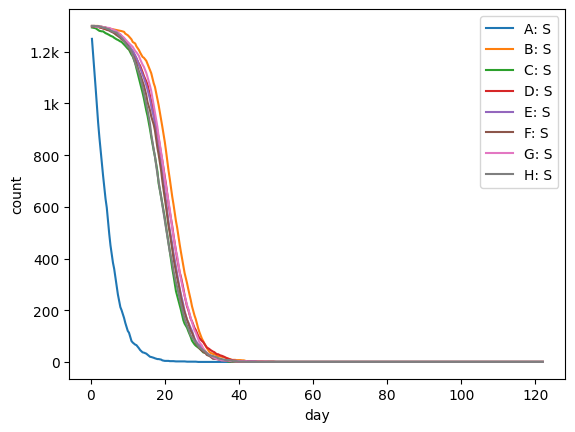

In [17]:
from epymorph.kit import *
from epymorph.adrio import us_tiger


rume = SingleStrataRUME.build(
    #ipm=ipm.SIRS(),
    ipm=SIRS_TREES(),
    #mm=mm.Centroids(),
    mm=Centroids(),
    #init=init.SingleLocation(location=0, seed_size=100),
    init=init.Explicit([
        [1_300, 0, 0, 0, 0, 0, 1_000],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0],
        [1_300, 0, 0, 0, 0, 0, 0]
    ]),
    #scope=StateScope.in_states(["AZ", "CO", "NM", "UT"], year=2020),
    scope=CustomScope(["A", "B", "C", "D", "E", "F", "G", "H"]),
    time_frame=TimeFrame.rangex("2023-05-01", "2023-08-31"),
    params={
        "beta": 0.3,
        "gamma": 1/5,
        "xi": 1/365,
        "population": [
            #4_151_502, # Arizona
            #4_773_714, # Colorado
            #4_117_522#, # New Mexico
            #4_271_616, # Utah
            1_326, #total tree population per 100m by 100m grid
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326
        ],
        "centroid": centroids,
    },
)

sim = BasicSimulator(rume)
output = sim.run(rng_factory=default_rng(42))

output.plot.line(
    geo=output.rume.scope.select.all(),
    time=output.rume.time_frame.select.all(),
    quantity=output.rume.ipm.select.compartments("S"),
)

# Multi-node Simulations with Movement Models
https://docs.www.epimorph.org/demo/G2.L0.1-MM_intro.html

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from epymorph.kit import *
from epymorph.adrio import acs5

In [ ]:
scope = CustomScope(["A", "B", "C", "D", "E", "F", "G", "H"])
scope.labels

In [ ]:
from epymorph.data.ipm.sirs import SIRS
sirs_ipm = SIRS()

In [ ]:
sirs_ipm.diagram()

In [ ]:
#Select your movement model by importing the movement model from the epymorph library called ‘Flat’. 
#This movement model includes random movement to and from a node. In other words, any individual has an equal chance of moving 
#to any other node in the system per time step. However,
#this model assumes individuals do not necessarily return to their original node.

from epymorph.data.mm.flat import Flat
flat_mm = Flat()

In [ ]:
#Initialize the state variables in our model (i.e., the initial values of S, I, and R). 
#In this scenario, the infection began in Maricopa County, Arizona with 5 infected individuals.

# scope "E" is the 5th node in the scope (i.e., index 4)
my_init = init.SingleLocation(location=4, seed_size=5)

In [ ]:
#Define your timeframe

time = TimeFrame.of("2023-05-01", duration_days=120)

In [ ]:
#Define a parameter that is required by the Flat movement model, called commuter_proportion. 
#This represents the fraction of individuals in a given node that move outside their node on a daily basis.

comm_prop = 0.15

In [ ]:
#Define the model parameters, ‘beta’ (transmission rate), ‘gamma’ (recovery rate), 
#and ‘xi’ (latency rate) to reasonable values.

beta = 0.4
gam = 1 / 4
xi = 1 / 200

In [ ]:
rume = SingleStrataRUME.build(
    scope=scope,
    ipm=sirs_ipm,
    mm=flat_mm,
    init=my_init,
    time_frame=time,
    params={
        'beta': beta,
        'gamma': gam,
        'xi': xi,
        "population": [
            #4_151_502, # Arizona
            #4_773_714, # Colorado
            #4_117_522#, # New Mexico
            #4_271_616, # Utah
            1_326, #total tree population per 100m by 100m grid
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326
        ],
        'commuter_proportion': comm_prop,
    }
)
# Print a description of params
print(rume.params_description())

In [ ]:
#RUN THE SIMULATION

sim = BasicSimulator(rume)
with sim_messaging(live = False):
    out = sim.run(
        rng_factory=default_rng(5),
    )

In [ ]:
#Plot the dynamics of the Infectious class over time as a single line for each county 
#and explore the differences in peak infection for each county. You’ll want to group by ‘day’ to aggregate 
#across the time ticks in the model imposed by the movement model.

out.plot.line(
    geo=out.rume.scope.select.all(),
    time=out.rume.time_frame.select.all().group("day").agg(),
    quantity=out.rume.ipm.select.compartments("I"),
    title="Infectious in 8 grid cells",
    legend="outside",
)

In [ ]:
#Use the quantile table feature to print the maximum infectious observed across the counties.
out.table.quantiles(
    quantiles=[1.0],
    geo=out.rume.scope.select.all(),
    time=out.rume.time_frame.select.all().group("day").agg(),
    quantity=out.rume.ipm.select.compartments("I"),
)

In [ ]:
import numpy as np

df = out.table.quantiles(
    quantiles=[1.0],
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group("day").agg(),
    quantity=rume.ipm.select.compartments("I"),
)

values = df["1.0"].to_numpy()
print(values)


In [ ]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Your centroid array (replace with real lat/lon when fixed)
centroids = np.array(
    [
        (-112, 36),
        (-112, 36),
        (-112, 36),
        (-112, 36),
        (-112, 36),
        (-112, 36),
        (-112, 36),
        (-112, 36),
    ]
)

# Example values from your simulation (replace with real data)
values = values  

# Build GeoDataFrame
gdf = gpd.GeoDataFrame(
    {"value": values},
    geometry=[Point(lon, lat) for lon, lat in centroids],
    crs="EPSG:4326"
)

# Plot choropleth-like points
gdf.plot(
    column="value",
    legend=True,
    cmap="viridis",
    markersize=100
)
plt.show()
